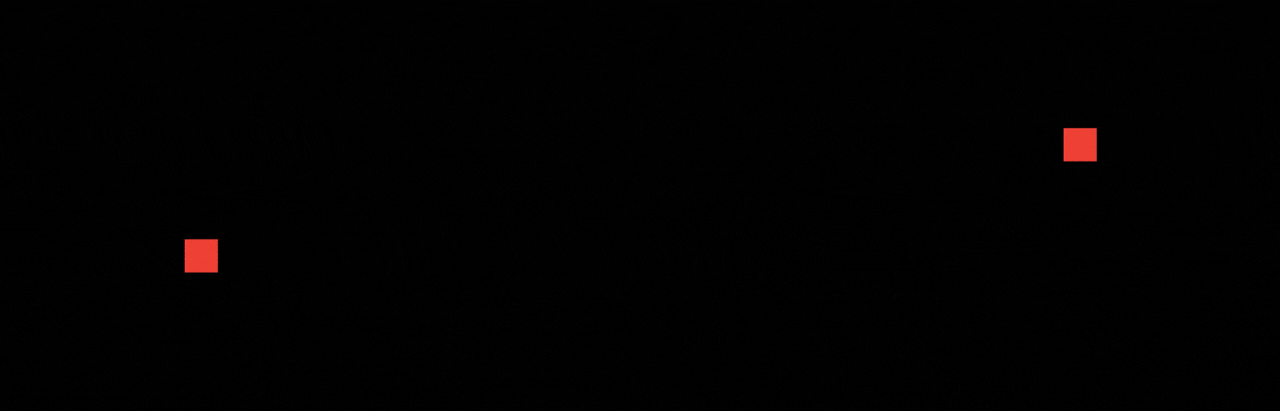


Business Problem:

Delhivery is the largest and fastest-growing fully integrated player in India by revenue in Fiscal 2021. They aim to build the operating system for commerce, through a combination of world-class infrastructure, logistics operations of the highest quality, and cutting-edge engineering and technology capabilities.

The team has to build intelligence and capabilities using this data that helps them to widen the gap between the quality, efficiency, and profitability of their business versus their competitors.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import sklearn.preprocessing as sl
import warnings
warnings.filterwarnings('ignore')

### Importing Delhivery data

In [ ]:
raw_data = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/551/original/delhivery_data.csv?1642751181')

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144867 entries, 0 to 144866
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   data                            144867 non-null  object 
 1   trip_creation_time              144867 non-null  object 
 2   route_schedule_uuid             144867 non-null  object 
 3   route_type                      144867 non-null  object 
 4   trip_uuid                       144867 non-null  object 
 5   source_center                   144867 non-null  object 
 6   source_name                     144574 non-null  object 
 7   destination_center              144867 non-null  object 
 8   destination_name                144606 non-null  object 
 9   od_start_time                   144867 non-null  object 
 10  od_end_time                     144867 non-null  object 
 11  start_scan_to_end_scan          144867 non-null  float64
 12  is_cutoff       

#### Null values treament

In [ ]:
pd.DataFrame((np.round(100*raw_data.isna().sum(axis = 0)/len(raw_data),3)).sort_values(ascending = False),columns = ['% Missing']).head(10)

,% Missing
source_name,0.202
destination_name,0.180
data,0.000
cutoff_factor,0.000
segment_osrm_distance,0.000
segment_osrm_time,0.000
segment_actual_time,0.000
factor,0.000
osrm_distance,0.000
osrm_time,0.000


Source Name and Destination name has minor missing or null values (less than 1%)


For Null values in Destination name column,

1. We can check and get the value by matching the destination center values in source center and extracting the source name column from matched source center.


In [ ]:
destination_name_nulls = raw_data.loc[raw_data['destination_name'].isnull(),'destination_center'].unique()
_source_name = raw_data.loc[raw_data['source_center'].isin(destination_name_nulls),['source_center','source_name']]
print('column length: ',len(_source_name))
_source_name.isna().sum(axis = 0)

column length:  290


,0
source_center,0
source_name,290


There is no data available in source name as well for missing destination_center code.

In [ ]:
source_name_nulls = raw_data.loc[raw_data['source_name'].isnull(),'source_center'].unique()
_destination_name = raw_data.loc[raw_data['destination_center'].isin(source_name_nulls),['destination_center','destination_name']]
print('column length: ',len(_destination_name))
_destination_name.isna().sum(axis = 0)

column length:  240


,0
destination_center,0
destination_name,240


There is no data available in destination name as well for missing source_center code.

Remove the null value rows from dataframe

In [ ]:
raw_data = raw_data.dropna(subset=['source_name','destination_name'],axis = 0)

Converting the trip_creation_time, od_start_time, od_end_time datatypes to datetime format.

In [ ]:
raw_data[['trip_creation_time','od_start_time','od_end_time']] = raw_data[['trip_creation_time','od_start_time','od_end_time']].apply(pd.to_datetime)
raw_data[['trip_creation_time','od_start_time','od_end_time']].dtypes

,0
trip_creation_time,datetime64[ns]
od_start_time,datetime64[ns]
od_end_time,datetime64[ns]


#### reduce the data shape by grouping the rows.

In [ ]:
data = raw_data.copy(deep = True)

#Sorting the delhivery data data based on trip unique id, order start and end time in ascending

cols = ['trip_uuid','od_start_time','od_end_time']
data = data.sort_values(by = cols ,ascending = [True,True,True]).reset_index(drop=True)

In [ ]:
dict_agg = {'segment_actual_time':np.cumsum,'segment_osrm_time':np.cumsum,'segment_osrm_distance':np.cumsum}
data[['segment_actual_time_sum','segment_osrm_time_sum','segment_osrm_distance_sum']] = data.groupby(cols).agg(dict_agg)

In [ ]:
create_segment_dict = {
    'data':'first', 'trip_creation_time':'first', 'route_schedule_uuid':'first', 'route_type':'first',
      'source_name':'first','destination_name':'last', 'od_start_time':'min', 'od_end_time':'max',
       'start_scan_to_end_scan':'first', 'actual_distance_to_destination':'last', 'actual_time':'last',
       'osrm_time':'last', 'osrm_distance':'last',
       'segment_actual_time_sum':'last', 'segment_osrm_time_sum':'last',
       'segment_osrm_distance_sum':'last'}

data = data.groupby(['trip_uuid','source_center','destination_center']).aggregate(create_segment_dict).reset_index()
data = data.sort_values(by=['trip_uuid','od_start_time','od_end_time'],ascending = [True,True,True]).reset_index(drop=True)


In [ ]:
data['od_time_diff_hours'] = np.round((data['od_end_time'] - data['od_start_time']).dt.total_seconds()/3600,2)

In [ ]:
cols_dict = {
    'source_center':'first', 'destination_center':'last', 'data':'first',
       'trip_creation_time':'max', 'route_schedule_uuid':'first', 'route_type':'first',
       'source_name':'first', 'destination_name':'last', 'od_start_time':'min', 'od_end_time':'max',
       'start_scan_to_end_scan':'sum', 'actual_distance_to_destination':'sum',
       'actual_time':'sum', 'osrm_time':'sum', 'osrm_distance':'sum', 'segment_actual_time_sum':'sum',
       'segment_osrm_time_sum':'sum', 'segment_osrm_distance_sum':'sum',
       'od_time_diff_hours':'sum'}

data = data.groupby('trip_uuid').aggregate(cols_dict).reset_index()

#### Feature Engineering

In [ ]:
#City-place-code (State) -> source_name, destination_name
data.source_name = data.source_name.str.lower()
data.destination_name = data.destination_name.str.lower()
data[['s1','source_state']] = data.source_name.str.extract(r'^([a-zA-Z0-9 &-_ ]+)\s\(([a-zA-Z0-9& ]+)\)$')
data[['d1','destination_state']] = data.destination_name.str.extract(r'^([a-zA-Z0-9 &-_ ]+)\s\(([a-zA-Z0-9& ]+)\)$')

In [ ]:
#City-place-code -> s1 and d1
#Checking the string format for edgecases detection.
data['s1'].str.split('_').str.len().value_counts()

,count
s1,
3,11432
4,1545
2,1170
1,640


In [ ]:
data.loc[data['s1'].str.split('_').str.len() == 1,'s1'].value_counts().head(7)

,count
s1,
mumbai hub,300
hbr layout pc,79
pnq pashan dpc,32
pnq vadgaon sheri dpc,28
faridabad,26
tiruchi,25
haridwar,18


we can correct these like below




* pnq rahatani dpc - pune_Rahatani_dpc
* mumbai antop hill - Mumbai_Antop Hill
* bhopal mp nagar - Bhopal_MP Nagar
* mumbai mahim - Mumbai_mahim
* pnq pashan dpc - Pune_pashan_dpc
* pnq vadgaon sheri dpc - Pune_vadgaon sheri_dpc
* hbr layout pc - Bangalore_hbr layout_pc

In [ ]:
def set_address_values(df):
  df = df.str.replace('pnq rahatani dpc','pune_rahatani_dpc')
  df = df.str.replace('mumbai antop hill','mumbai_antop hill')
  df = df.str.replace('bhopal mp nagar','bhopal_mp nagar')
  df = df.str.replace('mumbai mahim','mumbai_mahim')
  df = df.str.replace('pnq pashan dpc','pune_pashan_dpc')
  df = df.str.replace('pnq vadgaon sheri dpc','pune_vadgaon sheri_dpc')
  df = df.str.replace('hbr layout pc','bangalore_hbr layout_pc')
  return df


data['s1'] = set_address_values(data['s1'])
data['d1'] = set_address_values(data['d1'])

In [ ]:
#converting all the city_hub values to 'city hub'
data.loc[data['s1'].str.contains('^.*hub$'),'s1'] = data.loc[data['s1'].str.contains('^.*hub$'),'s1'].str.replace('_',' ')

In [ ]:
def get_city(val):
  if len(val.split('_'))>1:
    return val.split('_')[0]

  return val.split(' ')[0]

def adjust_city_names(val):
  if val == 'bengaluru':
    return 'bangalore'
  elif val == 'maa':
    return 'chennai'
  elif val == 'del':
    return 'delhi'
  elif val == 'ccu':
    return 'kolkata'
  return val

data['source_city'] = data['s1'].apply(get_city)
data['source_city'] = data['source_city'].apply(adjust_city_names)

data['destination_city'] = data['d1'].apply(get_city)
data['destination_city'] = data['destination_city'].apply(adjust_city_names)



def get_place(val):
  if len(val.split('_')) >= 3:
    return val.split('_')[1]

  if len(val.split('_')) == 2:
    return val.split('_')[0]
  return val.split(' ')[0]

data['source_place'] = data['s1'].apply(get_place)
data['destination_place'] = data['d1'].apply(get_place)



def get_code(val):
  if len(val.split('_')) >= 3:
    return val.split('_')[-1]
  return 'none'

data['source_code'] = data['s1'].apply(get_code)
data['destination_code'] = data['d1'].apply(get_code)



In [ ]:
data.head(2)

,trip_uuid,source_center,destination_center,data,trip_creation_time,route_schedule_uuid,route_type,source_name,destination_name,od_start_time,...,s1,source_state,d1,destination_state,source_city,destination_city,source_place,destination_place,source_code,destination_code
0,trip-153671041653548748,IND462022AAA,IND000000ACB,training,2018-09-12 00:00:16.535741,thanos::sroute:d7c989ba-a29b-4a0b-b2f4-288cdc6...,FTL,bhopal_trnsport_h (madhya pradesh),gurgaon_bilaspur_hb (haryana),2018-09-12 00:00:16.535741,...,bhopal_trnsport_h,madhya pradesh,gurgaon_bilaspur_hb,haryana,bhopal,gurgaon,trnsport,bilaspur,h,hb
1,trip-153671042288605164,IND572101AAA,IND562101AAA,training,2018-09-12 00:00:22.886430,thanos::sroute:3a1b0ab2-bb0b-4c53-8c59-eb2a2c0...,Carting,tumkur_veersagr_i (karnataka),chikblapur_shntisgr_d (karnataka),2018-09-12 00:00:22.886430,...,tumkur_veersagr_i,karnataka,chikblapur_shntisgr_d,karnataka,tumkur,chikblapur,veersagr,shntisgr,i,d


In [ ]:
data['trip_creation_month'] = data['trip_creation_time'].dt.month
data['trip_creation_day'] = data['trip_creation_time'].dt.day
data['trip_creation_dayname'] = data['trip_creation_time'].dt.day_name()
data['order_start_time'] = data['od_start_time'].dt.hour

In [ ]:
data["order_timeslot"] = data["order_start_time"].apply(lambda x: "Dawn (12am-4am)" if x<=4 else ("Early Morning (5am-9am)" if x<=9 else
 ("Noon (10am-16pm)" if x<=16 else
  ("Late Evening (17pm-21pm)" if x<=21 else
   "Night (22pm-12am)"))))

In [ ]:
#creating a column based on the weekend or not"""

data['is_weekend'] = data['trip_creation_dayname'].apply(lambda x: 1 if x in ['Saturday','Sunday'] else 0)

In [ ]:
#remove intermediate/unwanted columns from dataframe

data.drop(columns = ['s1','d1'],inplace = True)

#### Outliers Treatment

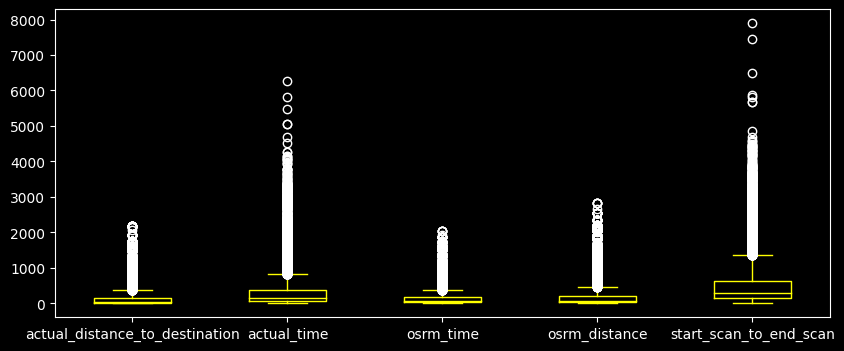

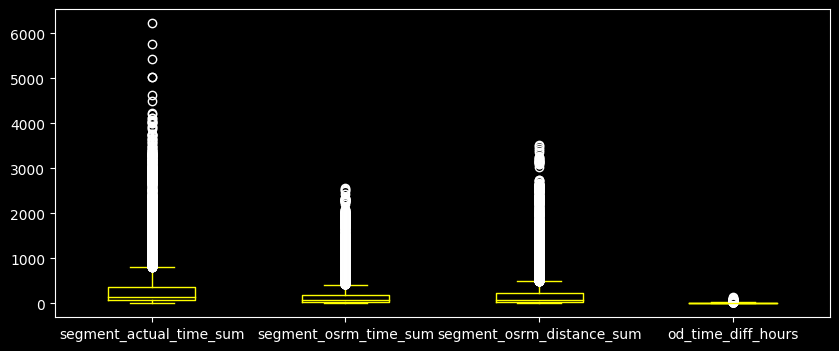

In [ ]:
#checking outliers from data for below columns

numerical_cols = ['actual_distance_to_destination','actual_time',
                  'osrm_time','osrm_distance','start_scan_to_end_scan',
                  'segment_actual_time_sum','segment_osrm_time_sum',
                  'segment_osrm_distance_sum','od_time_diff_hours']

plt.style.use('dark_background')

col1 = ['actual_distance_to_destination','actual_time','osrm_time',
        'osrm_distance','start_scan_to_end_scan']
data[col1].plot(kind = 'box',figsize = (10,4),color='yellow')

col2 = ['segment_actual_time_sum','segment_osrm_time_sum',
        'segment_osrm_distance_sum','od_time_diff_hours']
data[col2].plot(kind = 'box',figsize = (10,4),color='yellow')
plt.show()


In [ ]:
q1 = data[numerical_cols].quantile(0.25)
q3 = data[numerical_cols].quantile(0.75)
IQR = q3-q1

In [ ]:
data = data.loc[(~((data[numerical_cols] > (q3+IQR*1.5)) | (data[numerical_cols] < (q1-IQR*1.5))).any(axis = 1))].reset_index(drop=True)

In [ ]:
#Normalize the numerical data to avoid the differences in feature units.
df = data.copy(deep = True)
df[numerical_cols] = pd.DataFrame(sl.StandardScaler().fit_transform(data[numerical_cols]),columns= numerical_cols)

In [ ]:
df[numerical_cols].describe()

,actual_distance_to_destination,actual_time,osrm_time,osrm_distance,start_scan_to_end_scan,segment_actual_time_sum,segment_osrm_time_sum,segment_osrm_distance_sum,od_time_diff_hours
count,1.272300e+04,1.272300e+04,1.272300e+04,1.272300e+04,1.272300e+04,1.272300e+04,1.272300e+04,1.272300e+04,1.272300e+04
mean,-7.595206e-17,-8.041983e-17,4.467769e-17,3.797603e-17,-1.619566e-17,-3.127438e-17,6.031487e-17,-8.488760e-17,-6.729576e-17
std,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00
min,-8.785574e-01,-1.065181e+00,-1.001514e+00,-9.229378e-01,-1.162918e+00,-1.061764e+00,-1.003850e+00,-9.375981e-01,-1.163168e+00
25%,-7.065920e-01,-7.363685e-01,-7.111809e-01,-7.077649e-01,-7.207269e-01,-7.371165e-01,-7.274750e-01,-7.228116e-01,-7.199772e-01
50%,-4.689012e-01,-4.012322e-01,-3.931975e-01,-4.836339e-01,-3.411472e-01,-3.997380e-01,-4.134119e-01,-4.628077e-01,-3.424443e-01
75%,4.073375e-01,4.650634e-01,4.224989e-01,4.419548e-01,4.023595e-01,4.596223e-01,4.910897e-01,4.488499e-01,4.020692e-01
max,4.178358e+00,4.031419e+00,4.113871e+00,4.150641e+00,4.049455e+00,4.037107e+00,4.046283e+00,4.130135e+00,4.051944e+00


### Comparision of 'start_scan_to_end_scan' and 'od_time_diff_hours'

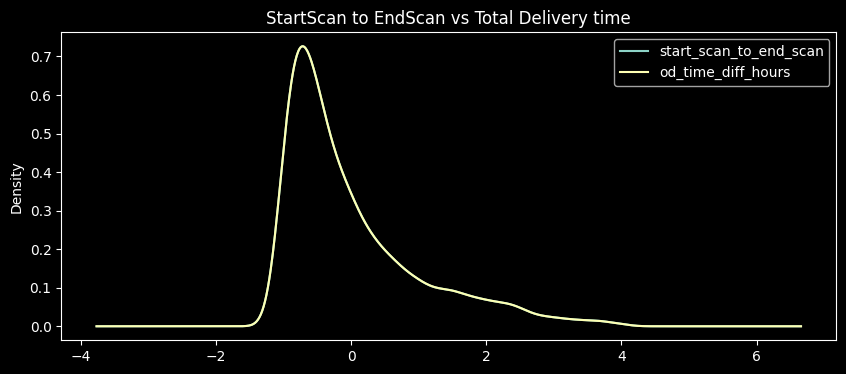

In [ ]:
df[['start_scan_to_end_scan','od_time_diff_hours']].plot(kind='density',figsize = (10,4),title='StartScan to EndScan vs Total Delivery time')
plt.show()

#Their distribution are similar to each other

In [ ]:
df[['start_scan_to_end_scan','od_time_diff_hours']].corr()

,start_scan_to_end_scan,od_time_diff_hours
start_scan_to_end_scan,1.000000,0.999997
od_time_diff_hours,0.999997,1.000000


In [ ]:
#Hypothesis testing
#H0 : 'start_scan_to_end_scan','od_time_diff_hours' are similar.
#H1 : 'start_scan_to_end_scan','od_time_diff_hours' are different.
_,p_value = stats.ttest_ind(df['start_scan_to_end_scan'],df['od_time_diff_hours'])
if p_value > 0.05:
  print("Accept the null hypothesis")
  print("There is no significance difference between 'start_scan_to_end_scan' and 'od_time_diff_hours'")
else:
  print("Reject the null hypothesis")
  print("There is a significant difference between 'start_scan_to_end_scan' and 'od_time_diff_hours'")

Accept the null hypothesis
There is no significance difference between 'start_scan_to_end_scan' and 'od_time_diff_hours'


### actual_time aggregated value and OSRM time aggregated value.

In [ ]:
#actual_time aggregated value and OSRM time aggregated value.
#actualtime is time taken to reach destination.
#OSRM is predicted time to reach destination

df[['actual_time','osrm_time']].sample(5)


,actual_time,osrm_time
12147,0.680056,0.408674
1661,0.401830,1.611480
12356,-0.957685,-0.863260
6339,-0.375939,-0.185817
6992,2.077511,2.634557


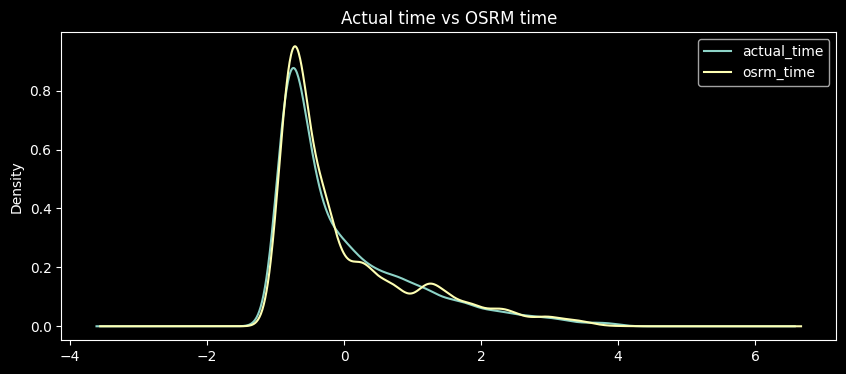

In [ ]:
df[['actual_time','osrm_time']].plot(kind='density',figsize = (10,4),title='Actual time vs OSRM time')
plt.show()

Distributions looks close to each other. Actual time and predicted time looks similar.

Lets check through statistical test.

In [ ]:


#Hypothesis testing
#H0 : 'actual_time' and 'osrm_time' are similar.
#H1 : 'actual_time' and 'osrm_time' are different.

_,p_value = stats.ttest_rel(df['actual_time'],df['osrm_time'])
if p_value > 0.05:
  print("Accept the null hypothesis")
  print("There is no significance difference between 'actual_time' and 'osrm_time'")
else:
  print("Reject the null hypothesis")
  print("There is a significant difference between 'actual_time' and 'osrm_time'")

statisticvalue,_=stats.spearmanr(df['actual_time'],df['osrm_time'])
print()
print(np.round(statisticvalue,2), "'actual_time' and 'osrm_time' are strongly correlated to each other")

Accept the null hypothesis
There is no significance difference between 'actual_time' and 'osrm_time'

0.87 'actual_time' and 'osrm_time' are strongly correlated to each other


####  hightraffic hrs and low traffic hrs segmented data

In [ ]:
#checking based on the shipment Time.
#Most of the orders are within cities.
#By changing data based on the usual traffic may help to find the ORSM time prediction effectiveness.
#Segmenting data into hightraffic hrs and low traffic hrs data.

hts_data = df.loc[df['order_timeslot'].isin(['Noon (10am-16pm)','Late Evening (17pm-21pm)'])]
lts_data = df.loc[df['order_timeslot'].isin(['Dawn (12am-4am)','Night (22pm-12am)'])]



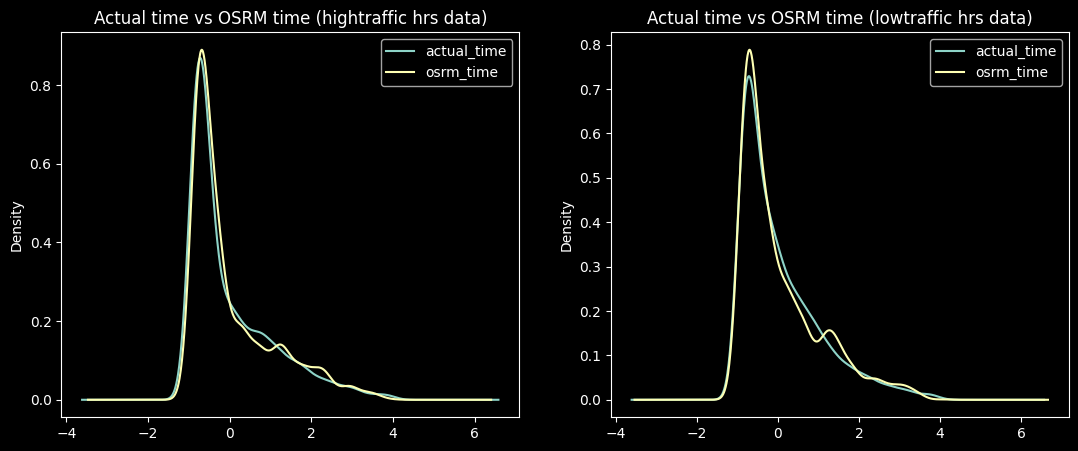

In [ ]:
_,ax=plt.subplots(1,2,figsize=(13,5))

cols = ['actual_time','osrm_time']
hts_data[cols].plot(kind = 'density',title = 'Actual time vs OSRM time (hightraffic hrs data)',ax=ax[0])
lts_data[cols].plot(kind = 'density',title = 'Actual time vs OSRM time (lowtraffic hrs data)',ax=ax[1])
plt.show()

* Distributions looks similar for both hightraffichrs data and low traffichrs data

In [ ]:
#checking though statistical method

#Hypothesis testing
#H0 : 'actual_time' and 'osrm_time' are similar.
#H1 : 'actual_time' and 'osrm_time' are different.

print('Hypothesis during High Trafic Hours','\n')
_,p_value = stats.ttest_rel(hts_data['actual_time'],hts_data['osrm_time'])
if p_value > 0.05:
  print("Accept the null hypothesis")
  print("There is no significance difference between 'actual_time' and 'osrm_time'")
else:
  print("Reject the null hypothesis")
  print("There is a significant difference between 'actual_time' and 'osrm_time'")

print('Hypothesis during Low Trafic Hours','\n')

_,p_value = stats.ttest_rel(lts_data['actual_time'],lts_data['osrm_time'])
if p_value > 0.05:
  print("Accept the null hypothesis")
  print("There is no significance difference between 'actual_time' and 'osrm_time'")
else:
  print("Reject the null hypothesis")
  print("There is a significant difference between 'actual_time' and 'osrm_time'")


Hypothesis during High Trafic Hours 

Reject the null hypothesis
There is a significant difference between 'actual_time' and 'osrm_time'
Hypothesis during Low Trafic Hours 

Accept the null hypothesis
There is no significance difference between 'actual_time' and 'osrm_time'


#### route type segmented data.

In [ ]:
#checking on the basis of route type(FTL vs Carting)
100*df['route_type'].value_counts(normalize = True)

,proportion
route_type,
Carting,69.260395
FTL,30.739605


In [ ]:
carting_data = df.loc[(df['route_type'] == 'Carting')]
ftl_data = df.loc[(df['route_type'] == 'FTL')]

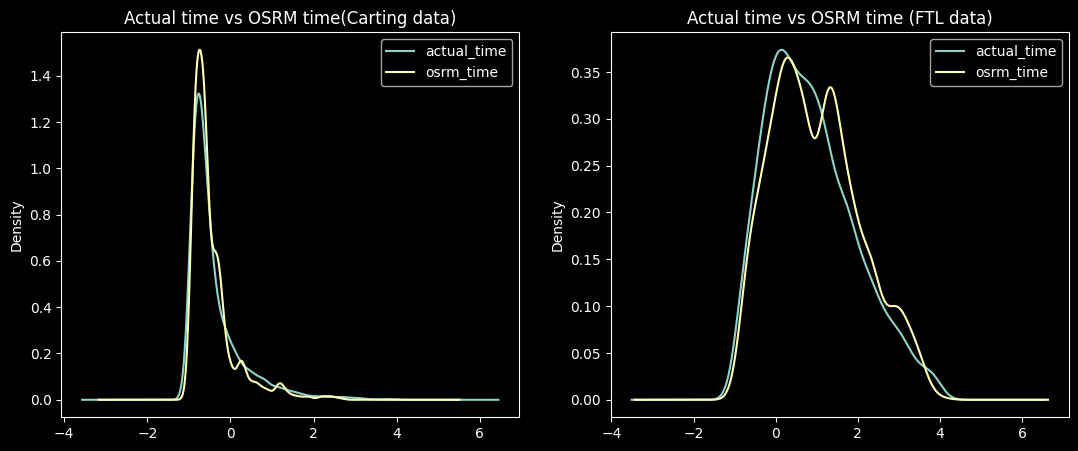

In [ ]:
_,ax=plt.subplots(1,2,figsize=(13,5))
cols = ['actual_time','osrm_time']
carting_data[cols].plot(kind = 'density',ax=ax[0],title = 'Actual time vs OSRM time(Carting data)')
ftl_data[cols].plot(kind = 'density',ax=ax[1],title = 'Actual time vs OSRM time (FTL data)')
plt.show()

* FTL data distribution seams slight deviated actual_time and osrm_data.
* Carting data distribution between actual_time and osrm_data looks similar.

In [ ]:
#Lets conclude thorugh statistical test

def test(data):
  #Hypothesis testing
  #H0 : 'actual_time' and 'osrm_time' are similar.
  #H1 : 'actual_time' and 'osrm_time' are different.
  _,p_value = stats.ttest_rel(data['actual_time'],data['osrm_time'])
  if p_value > 0.05:
    print("Accept the null hypothesis")
    print("There is no significance difference between 'actual_time' and 'osrm_time'")
  else:
    print("Reject the null hypothesis")
    print("There is a significant difference between 'actual_time' and 'osrm_time'")



In [ ]:
test(carting_data[['actual_time', 'osrm_time']])

Reject the null hypothesis
There is a significant difference between 'actual_time' and 'osrm_time'


In [ ]:
test(ftl_data[['actual_time','osrm_time']])

Reject the null hypothesis
There is a significant difference between 'actual_time' and 'osrm_time'


#### Type of data(training vs Test)

In [ ]:
#checking on basis of data(Testing vs Training)
train_data = df.loc[df['data'] == 'training']
test_data = df.loc[df['data'] == 'test']


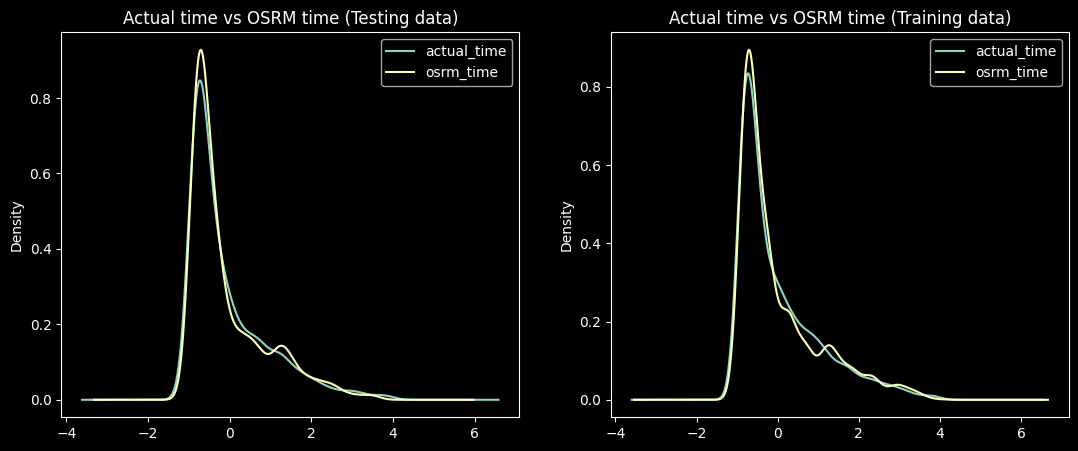

In [ ]:
_,ax = plt.subplots(1,2,figsize = (13,5))
cols = ['actual_time','osrm_time']
test_data[cols].plot(kind = 'density',ax= ax[0],title = 'Actual time vs OSRM time (Testing data)')
train_data[cols].plot(kind = 'density',ax= ax[1],title = 'Actual time vs OSRM time (Training data)')
plt.show()

In [ ]:
test(test_data[['actual_time', 'osrm_time']])

Accept the null hypothesis
There is no significance difference between 'actual_time' and 'osrm_time'


In [ ]:
test(train_data[['actual_time', 'osrm_time']])

Accept the null hypothesis
There is no significance difference between 'actual_time' and 'osrm_time'


* There is no signifincat difference between features 'actual_time' and 'osrm_time' for test and train data.

### OSRM distance aggregated value and segment OSRM distance

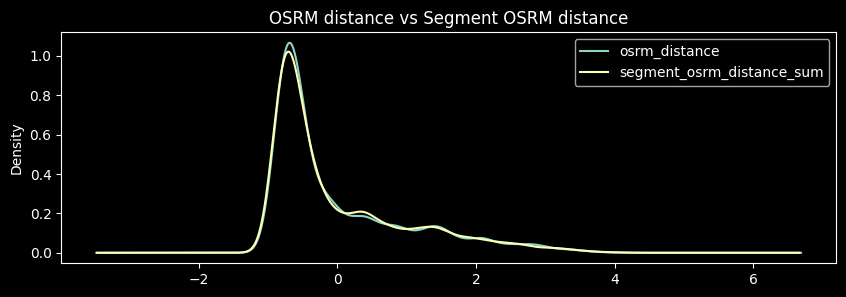

In [ ]:
cols = ['osrm_distance','segment_osrm_distance_sum']
df[cols].plot(kind = 'density',figsize = (10,3),title = 'OSRM distance vs Segment OSRM distance')
plt.show()

From above EDA analysis, OSRM distance and Segment OSRM distance are strongly correlated and similar distribution.

In [ ]:
#Statistical test
Spearman_coefficent,_ = stats.spearmanr(df['osrm_distance'],df['segment_osrm_distance_sum'])
print(np.round(Spearman_coefficent,2),' OSRM distance and Segment OSRM distance are strongly correlated')


def ttest_independent(data):
  #Hypothesis testing
  #H0 : 'osrm_distance' and 'segment_osrm_distance' are similiar.
  #H1 : 'osrm_distance' and 'segment_osrm_distance' are different.
  _,p_value = stats.ttest_ind(data['osrm_distance'],data['segment_osrm_distance_sum'])
  if p_value > 0.05:
    print("Accept the null hypothesis")
    print("There is no significance difference between 'osrm_distance' and 'segment_osrm_distance_sum'")
  else:
    print("Reject the null hypothesis")
    print("There is a significant difference between 'osrm_distance' and 'segment_osrm_distance_sum'")


print()

ttest_independent(df[['osrm_distance','segment_osrm_distance_sum']])


0.99  OSRM distance and Segment OSRM distance are strongly correlated

Accept the null hypothesis
There is no significance difference between 'osrm_distance' and 'segment_osrm_distance_sum'


#### hightraffic hrs and low traffic hrs segmented data

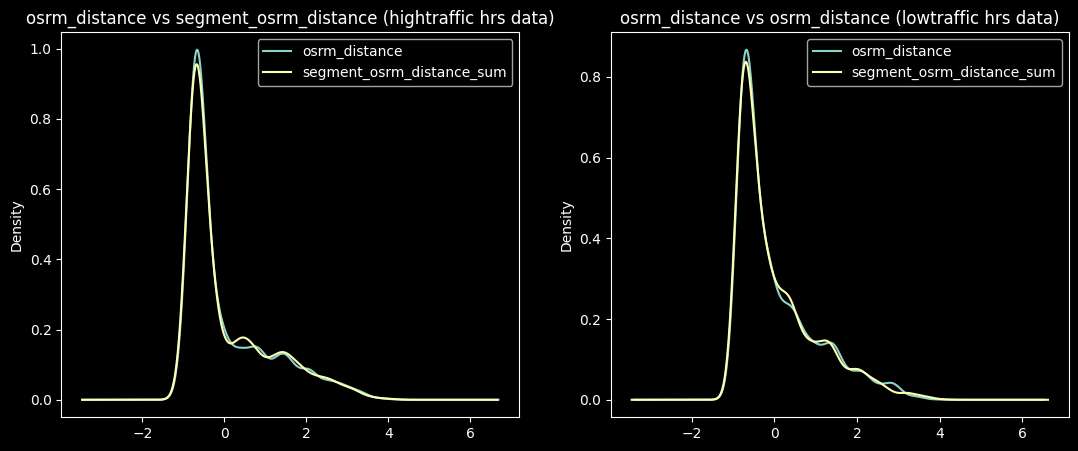

In [ ]:
_,ax=plt.subplots(1,2,figsize=(13,5))
cols = ['osrm_distance','segment_osrm_distance_sum']
hts_data[cols].plot(kind = 'density',title = 'osrm_distance vs segment_osrm_distance (hightraffic hrs data)',ax=ax[0])
lts_data[cols].plot(kind = 'density',title = 'osrm_distance vs osrm_distance (lowtraffic hrs data)',ax=ax[1])
plt.show()

* Distribution of OSRM distance and segment OSRM distance looks similar for both datasets.

In [ ]:
#checking though statistical method

#Hypothesis testing
#H0 : 'osrm_distance' and 'segment_osrm_distance' are similar.
#H1 : 'osrm_distance' and 'segment_osrm_distance' are different.

print('Hypothesis during High Trafic Hours','\n')
_,p_value = stats.ttest_ind(hts_data['osrm_distance'],hts_data['segment_osrm_distance_sum'])
if p_value > 0.05:
  print("Accept the null hypothesis")
  print("There is no significance difference between 'osrm_distance' and 'segment_osrm_distance_sum'")
else:
  print("Reject the null hypothesis")
  print("There is a significant difference between 'osrm_distance' and 'segment_osrm_distance_sum'")

print('Hypothesis during Low Trafic Hours','\n')

_,p_value = stats.ttest_ind(lts_data['osrm_distance'],lts_data['segment_osrm_distance_sum'])
if p_value > 0.05:
  print("Accept the null hypothesis")
  print("There is no significance difference between 'osrm_distance' and 'segment_osrm_distance_sum'")
else:
  print("Reject the null hypothesis")
  print("There is a significant difference between 'osrm_distance' and 'segment_osrm_distance_sum'")


Hypothesis during High Trafic Hours 

Accept the null hypothesis
There is no significance difference between 'osrm_distance' and 'segment_osrm_distance_sum'
Hypothesis during Low Trafic Hours 

Accept the null hypothesis
There is no significance difference between 'osrm_distance' and 'segment_osrm_distance_sum'


#### route type segmented data.

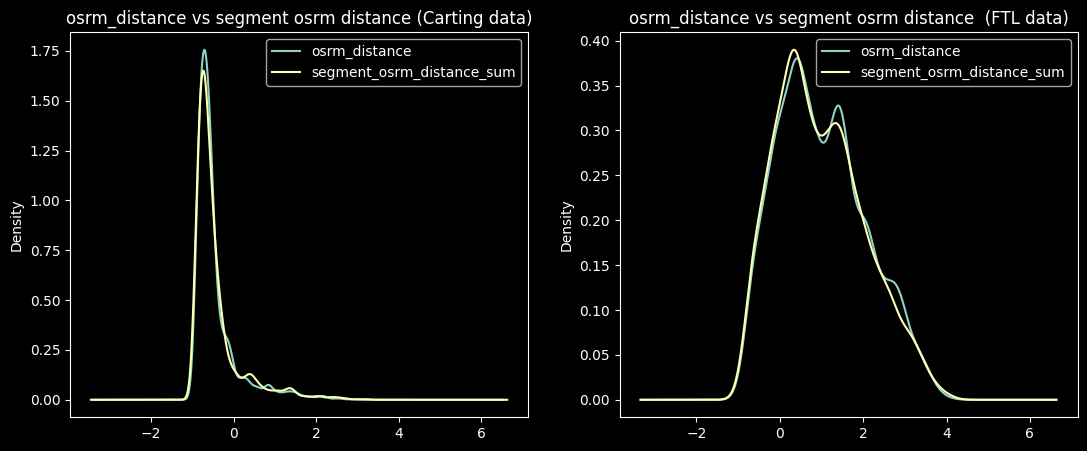

In [ ]:
#checking based on route type
_,ax=plt.subplots(1,2,figsize=(13,5))
cols = ['osrm_distance','segment_osrm_distance_sum']
carting_data[cols].plot(kind = 'density',ax=ax[0],title = 'osrm_distance vs segment osrm distance (Carting data)')
ftl_data[cols].plot(kind = 'density',ax = ax[1],title = 'osrm_distance vs segment osrm distance  (FTL data)')
plt.show()


* Carting and FTL data distribution between osrm_distance and segment osrm distance looks similar.




In [ ]:
ttest_independent(carting_data[['osrm_distance','segment_osrm_distance_sum']])

Reject the null hypothesis
There is a significant difference between 'osrm_distance' and 'segment_osrm_distance_sum'


In [ ]:
ttest_independent(ftl_data[['osrm_distance','segment_osrm_distance_sum']])

Accept the null hypothesis
There is no significance difference between 'osrm_distance' and 'segment_osrm_distance_sum'


#### Type of data(training vs Test)

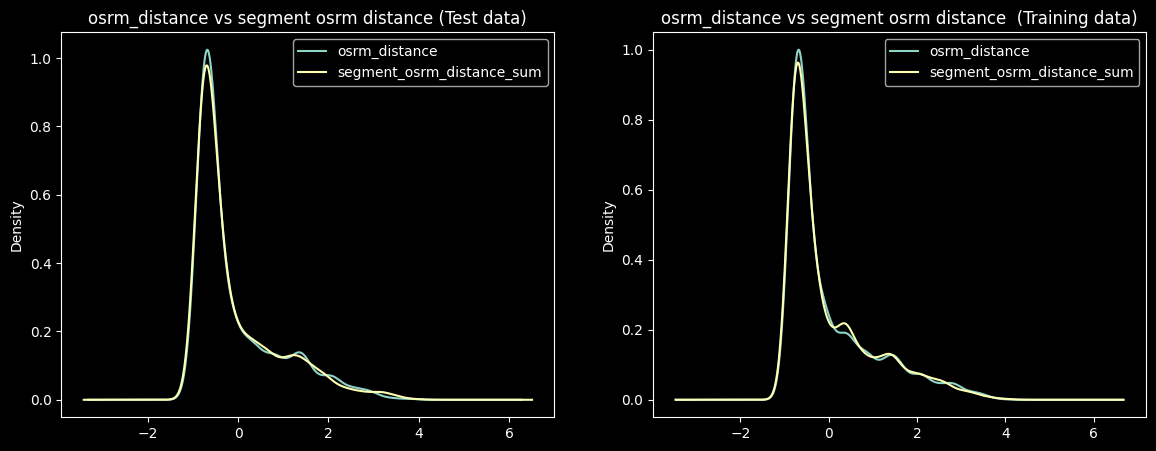

In [ ]:
#checking based on data type
_,ax=plt.subplots(1,2,figsize=(14,5))
cols = ['osrm_distance','segment_osrm_distance_sum']
test_data[cols].plot(kind = 'density',ax = ax[0],title = 'osrm_distance vs segment osrm distance (Test data)')
train_data[cols].plot(kind = 'density',ax=ax[1],title = 'osrm_distance vs segment osrm distance  (Training data)')
plt.show()

In [ ]:
ttest_independent(test_data[['osrm_distance','segment_osrm_distance_sum']])

Accept the null hypothesis
There is no significance difference between 'osrm_distance' and 'segment_osrm_distance_sum'


In [ ]:
ttest_independent(train_data[['osrm_distance','segment_osrm_distance_sum']])

Accept the null hypothesis
There is no significance difference between 'osrm_distance' and 'segment_osrm_distance_sum'


### OSRM time aggregated value and segment OSRM time aggregated value

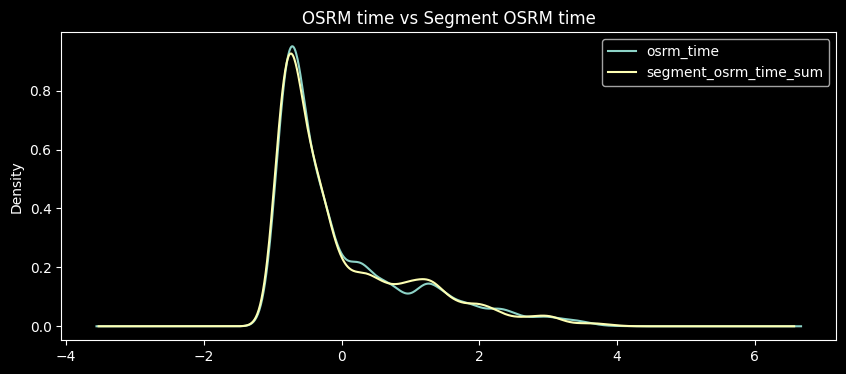

In [ ]:
cols = ['osrm_time','segment_osrm_time_sum']
df[cols].plot(kind = 'density',figsize = (10,4),title = 'OSRM time vs Segment OSRM time')
plt.show()

From above EDA analysis, OSRM time and Segment OSRM time are strongly correlated and similar distribution

In [ ]:
#Statistical test
Spearman_coefficent,_ = stats.spearmanr(df['osrm_time'],df['segment_osrm_time_sum'])
print(np.round(Spearman_coefficent,2),'OSRM time and Segment OSRM time are strongly correlated')


def ttest_independent_test(data):
  #Hypothesis testing
  #H0 : 'osrm_time' and 'segment_osrm_time' are similiar.
  #H1 : 'osrm_time' and 'segment_osrm_time' are different.
  _,p_value = stats.ttest_ind(data['osrm_time'],data['segment_osrm_time_sum'])
  if p_value > 0.05:
    print("Accept the null hypothesis")
    print("There is no significance difference between 'osrm_time' and 'segment_osrm_time_sum'")
  else:
    print("Reject the null hypothesis")
    print("There is a significant difference between 'osrm_time' and 'segment_osrm_time_sum'")


print()

ttest_independent_test(df[['osrm_time','segment_osrm_time_sum']])


0.99 OSRM time and Segment OSRM time are strongly correlated

Accept the null hypothesis
There is no significance difference between 'osrm_time' and 'segment_osrm_time_sum'


#### hightraffic hrs and low traffic hrs segmented data


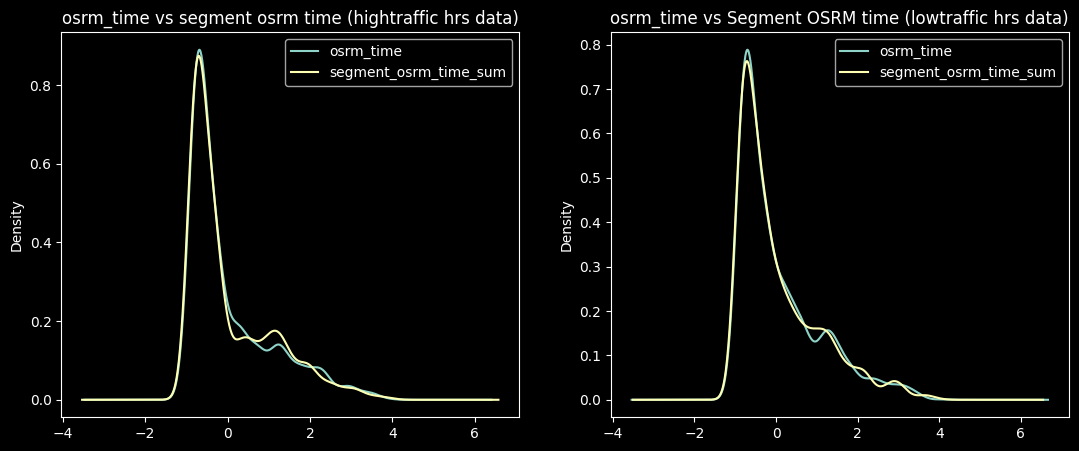

In [ ]:
# checkingg for highttrffic hrs and lowTraffic hrs segments.
_,ax=plt.subplots(1,2,figsize=(13,5))
cols = ['osrm_time','segment_osrm_time_sum']
hts_data[cols].plot(kind = 'density',title = 'osrm_time vs segment osrm time (hightraffic hrs data)',ax=ax[0])
lts_data[cols].plot(kind = 'density',title = 'osrm_time vs Segment OSRM time (lowtraffic hrs data)',ax=ax[1])
plt.show()

In [ ]:
#checking though statistical method

#Hypothesis testing
#H0 : 'osrm_distance' and 'segment_osrm_distance' are similar.
#H1 : 'osrm_distance' and 'segment_osrm_distance' are different.

print('Hypothesis during High Trafic Hours','\n')
_,p_value = stats.ttest_ind(hts_data['osrm_time'],hts_data['segment_osrm_time_sum'])
if p_value > 0.05:
  print("Accept the null hypothesis")
  print("There is no significance difference between 'osrm_time' and 'segment_osrm_time'")
else:
  print("Reject the null hypothesis")
  print("There is a significant difference between 'osrm_time' and 'segment_osrm_time'")

print('Hypothesis during Low Trafic Hours','\n')

_,p_value = stats.ttest_ind(lts_data['osrm_time'],lts_data['segment_osrm_time_sum'])
if p_value > 0.05:
  print("Accept the null hypothesis")
  print("There is no significance difference between 'osrm_time' and 'segment_osrm_time'")
else:
  print("Reject the null hypothesis")
  print("There is a significant difference between 'osrm_time' and 'segment_osrm_time'")


Hypothesis during High Trafic Hours 

Accept the null hypothesis
There is no significance difference between 'osrm_time' and 'segment_osrm_time'
Hypothesis during Low Trafic Hours 

Accept the null hypothesis
There is no significance difference between 'osrm_time' and 'segment_osrm_time'


#### route type segmented data.

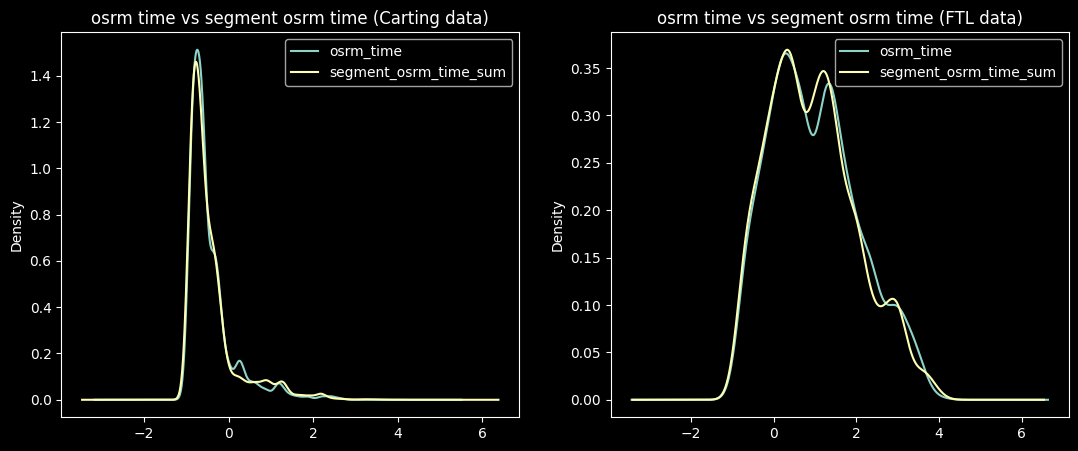

In [ ]:
#checking based on route type
_,ax=plt.subplots(1,2,figsize=(13,5))
cols = ['osrm_time','segment_osrm_time_sum']
carting_data[cols].plot(kind = 'density',ax=ax[0],title = 'osrm time vs segment osrm time (Carting data)')
ftl_data[cols].plot(kind = 'density',ax=ax[1],title = 'osrm time vs segment osrm time (FTL data)')
plt.show()

In [ ]:
ttest_independent_test(carting_data[['osrm_time','segment_osrm_time_sum']])

Reject the null hypothesis
There is a significant difference between 'osrm_time' and 'segment_osrm_time_sum'


In [ ]:
ttest_independent_test(ftl_data[['osrm_time','segment_osrm_time_sum']])

Reject the null hypothesis
There is a significant difference between 'osrm_time' and 'segment_osrm_time_sum'


#### Type of data(training vs Test)

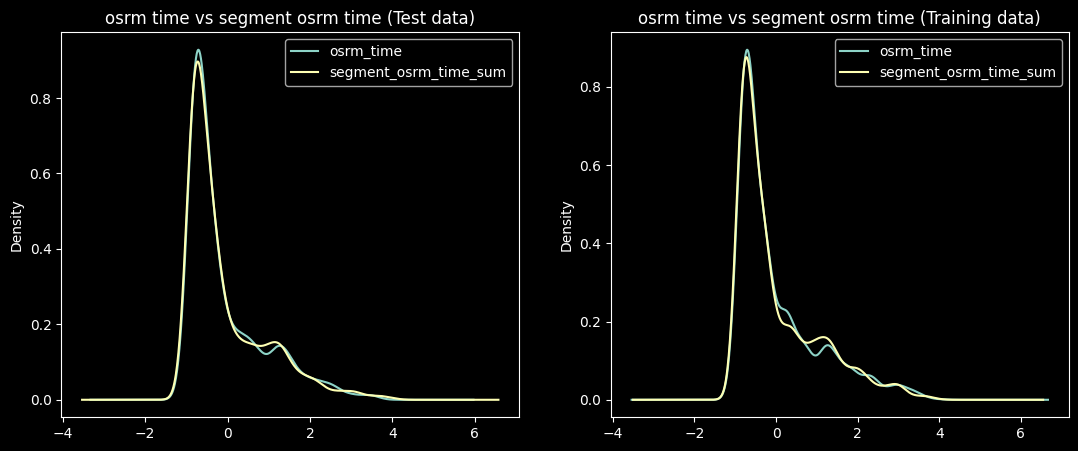

In [ ]:
#checking based on data type
_,ax=plt.subplots(1,2,figsize=(13,5))
cols = ['osrm_time','segment_osrm_time_sum']
test_data[cols].plot(kind = 'density',ax=ax[0],title = 'osrm time vs segment osrm time (Test data)')
train_data[cols].plot(kind = 'density',ax=ax[1],title = 'osrm time vs segment osrm time (Training data)')
plt.show()

In [ ]:
ttest_independent_test(test_data[['osrm_time','segment_osrm_time_sum']])

Accept the null hypothesis
There is no significance difference between 'osrm_time' and 'segment_osrm_time_sum'


In [ ]:
ttest_independent_test(train_data[['osrm_time','segment_osrm_time_sum']])

Accept the null hypothesis
There is no significance difference between 'osrm_time' and 'segment_osrm_time_sum'


### Observed Patterns

In [ ]:
temp = df['trip_creation_time'].dt.month.value_counts().reset_index()
temp.columns = ['month','count']
temp.loc[temp['month'] == 9,'count'] = (temp.loc[temp['month'] == 9,'count']/18).round(2)
temp.loc[temp['month'] == 10,'count'] = (temp.loc[temp['month'] == 10,'count']/3).round(2)
temp

,month,count
0,9,620.67
1,10,517.00


* September month has high deliveries comparing to october month

In [ ]:
df['trip_creation_dayname'].value_counts()

,count
trip_creation_dayname,
Wednesday,2352
Saturday,1836
Thursday,1819
Friday,1774
Tuesday,1766
Monday,1697
Sunday,1479


In [ ]:
temp = (np.round(100*df['source_state'].value_counts()/len(df['source_state']),3))
temp.name = '% of source_state'
temp.head()

,% of source_state
source_state,
maharashtra,18.077
karnataka,16.003
haryana,10.461
tamil nadu,8.213
delhi,5.242


* Most orders are placed from Maharastra and Karnataka

In [ ]:
temp = 100*df[['source_state','destination_state']].value_counts()/len(df['source_state'])
temp.name = '% of orders'
temp.head()

,,% of orders
source_state,destination_state,
maharashtra,maharashtra,17.849564
karnataka,karnataka,15.562367
tamil nadu,tamil nadu,7.946239
haryana,haryana,6.177788
telangana,telangana,4.959522


* Most orders are within the state of maharastra, karnataka, tamil nadu, haryana.

In [ ]:
temp = pd.DataFrame(100*df[['source_city','destination_city']].value_counts()/len(df))
temp.columns = ['% of orders']
temp.head()

,,% of orders
source_city,destination_city,
bangalore,bangalore,12.072624
mumbai,mumbai,4.708009
chennai,chennai,4.354319
bhiwandi,mumbai,3.426865
hyderabad,hyderabad,2.978857


* Most orders are within the city of bangalore, mumbai, chennai.
* There is significant orders from bhiwandi to mumbai.

In [ ]:
cols = ['source_city','source_place','destination_city','destination_place']
arr = df[cols].value_counts().head(10).reset_index().iloc[:,0:-1].values

In [ ]:
a1 = list()
for s_city,s_place,d_city,d_place in arr:
  temp = data.loc[(df['source_place'] == s_place) & (df['source_city'] == s_city) & (df['destination_place'] == d_place) & (df['destination_city'] == d_city)]
  temp['actual_time'].mean(),temp['actual_distance_to_destination'].mean()
  a1+=[[s_city,s_place,d_city,d_place,np.round(temp['actual_time'].mean()),
        np.round(temp['actual_distance_to_destination'].mean()),np.round(temp['osrm_distance'].mean()),
        np.round(temp['osrm_time'].mean())]]

In [ ]:
cols = ['source_city','source_place','destination_city','destination_place',
        'avg_actual_time','avg_actual_distance','avg_osrm_distance','avg_osrm_time']
pd.DataFrame(a1,columns = cols)

,source_city,source_place,destination_city,destination_place,avg_actual_time,avg_actual_distance,avg_osrm_distance,avg_osrm_time
0,bangalore,nelmngla,bangalore,kgairprt,88.0,28.0,38.0,48.0
1,chandigarh,mehmdpur,chandigarh,mehmdpur,337.0,154.0,190.0,161.0
2,bangalore,bomsndra,bangalore,kgairprt,115.0,42.0,53.0,57.0
3,bhiwandi,mankoli,bhiwandi,mankoli,241.0,85.0,108.0,83.0
4,bangalore,kgairprt,bangalore,nelmngla,105.0,28.0,41.0,50.0
5,ahmedabad,east,ahmedabad,east,124.0,39.0,46.0,39.0
6,bhiwandi,mankoli,mumbai,mumbai,61.0,21.0,27.0,22.0
7,mumbai,chndivli,bhiwandi,mankoli,81.0,20.0,26.0,21.0
8,bangalore,nelmngla,bangalore,bomsndra,95.0,40.0,50.0,50.0
9,gurgaon,bilaspur,sonipat,kundli,216.0,70.0,98.0,97.0


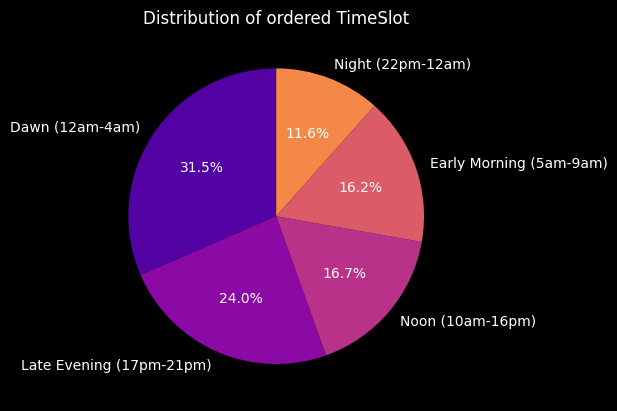

In [ ]:

clr = sns.color_palette('plasma')
plt.pie(x = df['order_timeslot'].value_counts(),labels = df['order_timeslot'].value_counts().index,autopct = '%1.1f%%',startangle=90,colors = clr)
plt.title('Distribution of ordered TimeSlot')
plt.show()

In [ ]:
temp = pd.DataFrame(np.round(100*df[['source_city','order_timeslot']].value_counts()/len(df),2))
temp.columns = ['% of orders']
temp.head(12)

% of orders
source_city order_timeslot                       
bangalore   Late Evening (17pm-21pm)         3.73
            Dawn (12am-4am)                  2.82
            Early Morning (5am-9am)          2.74
            Noon (10am-16pm)                 2.69
mumbai      Dawn (12am-4am)                  2.15
gurgaon     Late Evening (17pm-21pm)         2.12
mumbai      Late Evening (17pm-21pm)         2.11
delhi       Late Evening (17pm-21pm)         1.70
gurgaon     Noon (10am-16pm)                 1.52
            Dawn (12am-4am)                  1.45
bhiwandi    Noon (10am-16pm)                 1.38
            Late Evening (17pm-21pm)         1.38

* Most delhiveries shipping are intiated during dawn & late night.
* Banglore and Mumbai has highest percent in orders. Most of them were shipped in During late evening and dawn hours.

In [ ]:
# weekend column

df['is_weekend'].value_counts()

,count
is_weekend,
0,9408
1,3315


In [ ]:
100*pd.crosstab(df['order_timeslot'],df['is_weekend'],normalize = True).sort_values(by=[0,1],ascending = [False,False])

is_weekend,0,1
order_timeslot,,
Dawn (12am-4am),22.919123,8.590741
Late Evening (17pm-21pm),17.841704,6.122770
Noon (10am-16pm),12.481333,4.252142
Early Morning (5am-9am),11.946868,4.275721
Night (22pm-12am),8.755797,2.813802


* Most of the shipments were done at Dawn and Late Evening irrespective of day.

#### is_weekend, shipment_timeslot feature effects on OSRM and Actual time

In [ ]:
#OSRM time, #Actual Time, #is_weekend, #shipment_timeslot

w0= df.loc[df['is_weekend'] == 0]
w1 = df.loc[df['is_weekend'] == 1]



In [ ]:


hts_w0_data = w0.loc[df['order_timeslot'].isin(['Noon (10am-16pm)','Late Evening (17pm-21pm)'])]
lts_w0_data = w0.loc[df['order_timeslot'].isin(['Dawn (12am-4am)','Night (22pm-12am)'])]


hts_w1_data = w1.loc[df['order_timeslot'].isin(['Noon (10am-16pm)','Late Evening (17pm-21pm)'])]
lts_w1_data = w1.loc[df['order_timeslot'].isin(['Dawn (12am-4am)','Night (22pm-12am)'])]



In [ ]:
def hypothesis_test(df,val,col):
  print()
  print('Hypothesis during '+val+' Hours')
  _,p_value = stats.ttest_rel(df[col[0]],df[col[1]])
  print()
  if p_value > 0.05:
    print("Accept the null hypothesis")
    print("There is no significance difference between '"+col[0]+"' and '"+col[1]+"'")
  else:
    print("Reject the null hypothesis")
    print("There is a significant difference between '"+col[0]+"' and '"+col[1]+"'")

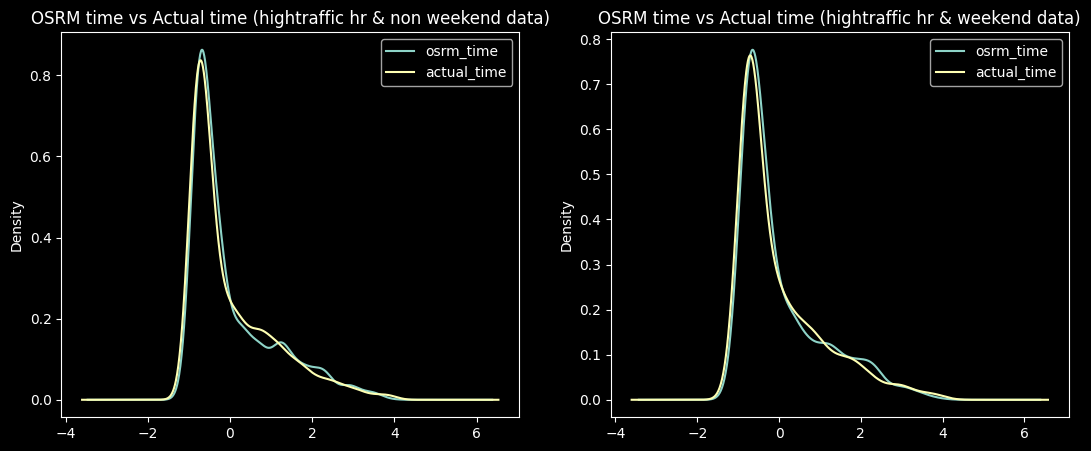


Hypothesis during hightraffic hr & non weekend data Hours

Reject the null hypothesis
There is a significant difference between 'osrm_time' and 'actual_time'

Hypothesis during hightraffic hr & weekend data Hours

Reject the null hypothesis
There is a significant difference between 'osrm_time' and 'actual_time'


In [ ]:
_,ax = plt.subplots(1,2,figsize=(13,5))
cols = ['osrm_time','actual_time']
hts_w0_data[cols].plot(kind = 'density',ax=ax[0],title = 'OSRM time vs Actual time (hightraffic hr & non weekend data)')
hts_w1_data[cols].plot(kind = 'density',ax = ax[1],title = 'OSRM time vs Actual time (hightraffic hr & weekend data)')
plt.show()

hypothesis_test(hts_w0_data, 'hightraffic hr & non weekend data', ['osrm_time','actual_time'])
hypothesis_test(hts_w1_data, 'hightraffic hr & weekend data', ['osrm_time','actual_time'])

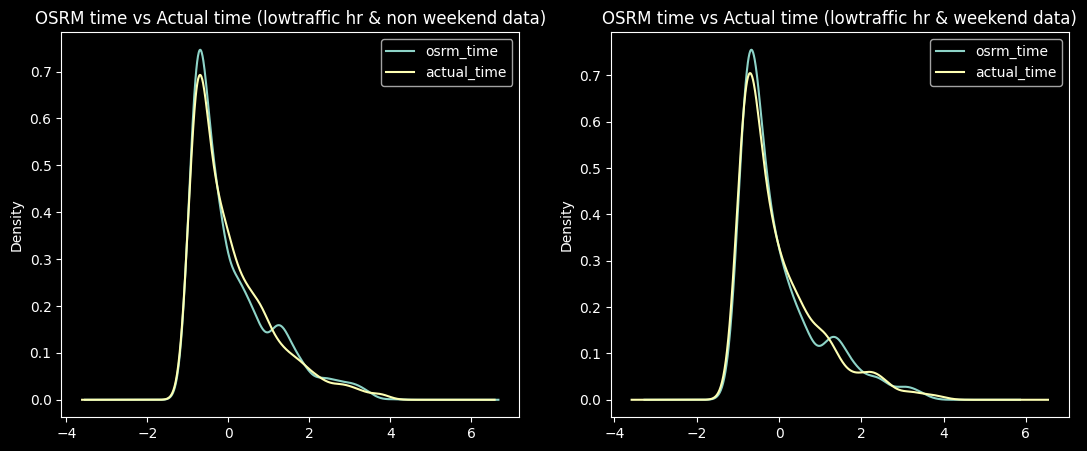


Hypothesis during lowtraffic hr & non weekend data Hours

Accept the null hypothesis
There is no significance difference between 'osrm_time' and 'actual_time'

Hypothesis during lowtraffic hr & weekend data Hours

Accept the null hypothesis
There is no significance difference between 'osrm_time' and 'actual_time'


In [ ]:
_,ax = plt.subplots(1,2,figsize=(13,5))
cols = ['osrm_time','actual_time']
lts_w0_data[cols].plot(kind = 'density',ax=ax[0],title = 'OSRM time vs Actual time (lowtraffic hr & non weekend data)')
lts_w1_data[cols].plot(kind = 'density',ax = ax[1],title = 'OSRM time vs Actual time (lowtraffic hr & weekend data)')
plt.show()


hypothesis_test(lts_w0_data, 'lowtraffic hr & non weekend data', ['osrm_time','actual_time'])
hypothesis_test(lts_w1_data, 'lowtraffic hr & weekend data', ['osrm_time','actual_time'])

* Model predicts less time comparing to actual time in all days during High trafic Hrs.

In [ ]:
# Comparing the actual_time and osrm_time with test and train data under different ordered timeslots


hts_train_data = train_data.loc[train_data['order_timeslot'].isin(['Noon (10am-16pm)','Late Evening (17pm-21pm)'])]
lts_train_data = train_data.loc[train_data['order_timeslot'].isin(['Dawn (12am-4am)','Night (22pm-12am)'])]



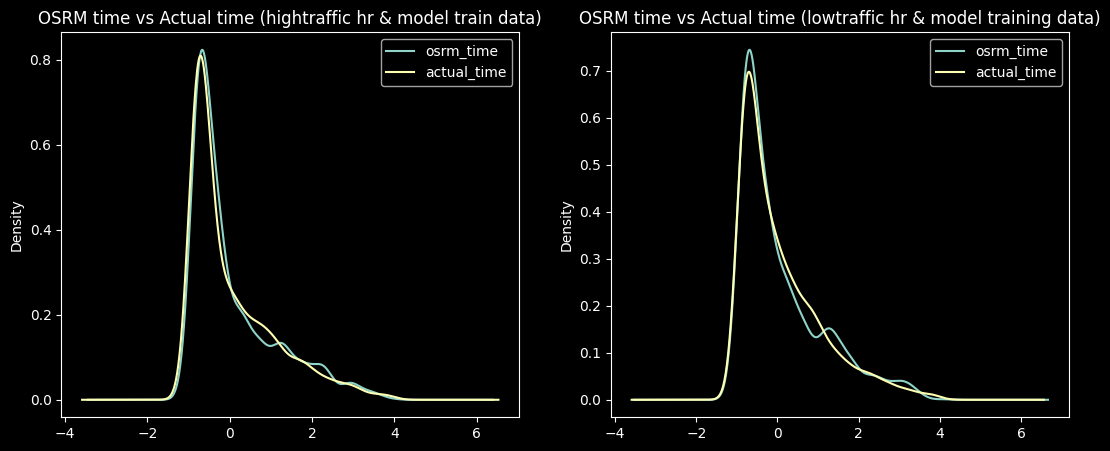


Hypothesis during hightraffic hr & model train data Hours

Reject the null hypothesis
There is a significant difference between 'osrm_time' and 'actual_time'

Hypothesis during lowtraffic hr & model train data Hours

Accept the null hypothesis
There is no significance difference between 'osrm_time' and 'actual_time'


In [ ]:
_,ax = plt.subplots(1,2,figsize=(13,5))
cols = ['osrm_time','actual_time']
hts_train_data[cols].plot(kind = 'density',ax=ax[0],title = 'OSRM time vs Actual time (hightraffic hr & model train data)')
lts_train_data[cols].plot(kind = 'density',ax = ax[1],title = 'OSRM time vs Actual time (lowtraffic hr & model training data)')
plt.show()


hypothesis_test(hts_train_data, 'hightraffic hr & model train data', ['osrm_time','actual_time'])
hypothesis_test(lts_train_data, 'lowtraffic hr & model train data', ['osrm_time','actual_time'])

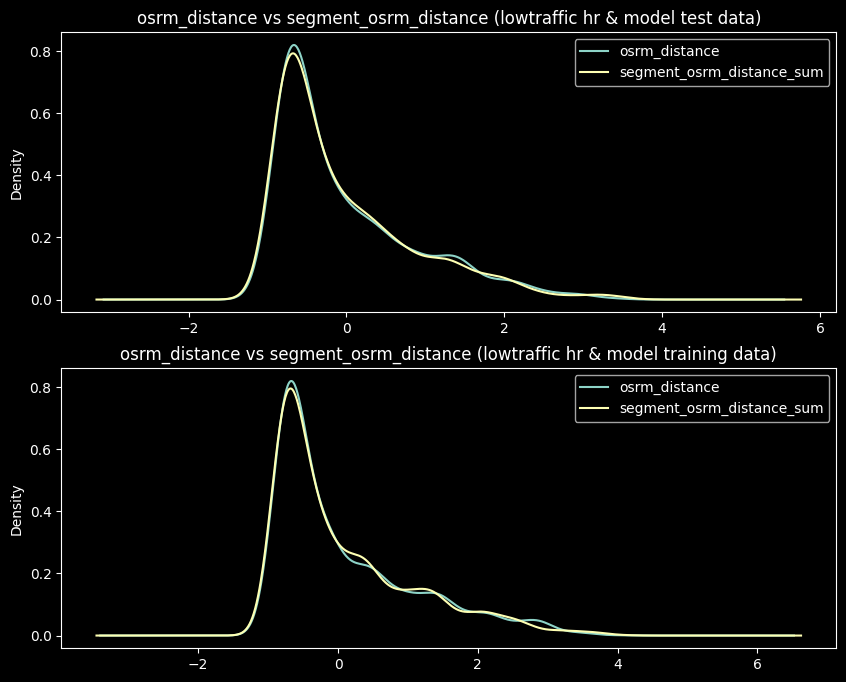


Hypothesis during lowtraffic hr & model test data Hours

Accept the null hypothesis
There is no significance difference between 'osrm_distance' and 'segment_osrm_distance_sum'

Hypothesis during lowtraffic hr & model training data Hours

Reject the null hypothesis
There is a significant difference between 'osrm_distance' and 'segment_osrm_distance_sum'


In [ ]:
_,ax = plt.subplots(2,1,figsize=(10,8))
cols = ['osrm_distance','segment_osrm_distance_sum']
lts_test_data[cols].plot(kind = 'density',ax=ax[0],title = 'osrm_distance vs segment_osrm_distance (lowtraffic hr & model test data)')

lts_train_data[cols].plot(kind = 'density',ax = ax[1],title = 'osrm_distance vs segment_osrm_distance (lowtraffic hr & model training data)')
plt.show()


hypothesis_test(lts_test_data, 'lowtraffic hr & model test data', ['osrm_distance','segment_osrm_distance_sum'])
hypothesis_test(lts_train_data, 'lowtraffic hr & model training data', ['osrm_distance','segment_osrm_distance_sum'])

### Observations

* During High traffic hrs., model time prediction is slightly deviating from actual hours.
* No significance difference between actual time and osrm time during low traffic hours.
* OSRM and Segment OSRM distance and time has no significance difference.
* Actual and OSRM time ,OSRM and Segment OSRM time has significant changes for different route types.
* Most orders are placed and delivered with in states of Maharashtra and Karnataka, TamilNadu.
* More orders inflow with in capitals Bangalore, Mumbai, Chennai (Possibility to the high inflow of air logistics and urbanization demand).
*Lot of delhivery orders created or shipped at late evenings,night and early morning timeslots.(It could strategy day delivery service).
* Most orders created/shipping are initiated during dawn ,late evenings & late night (It could strategy day delivery service).
*Bangalore ,Mumbai, Gurgaon and Delhi has highest percent in orders. Most of them were shipped in During late evening and dawn hours irrespective of day.
* OSRM and Segment OSRM distance and time are highly corelated to each other.


### Recommendations

* Training data showing the significant difference of prediction in time and distance. Refine the training data, to predict the actual time and segment orsm distance properly.

* Improve route planning algorithms and enhancing the delivery process experience for high traffic routes and  warehouse/shipment cities.

* Offer flexible delivery options such as express delivery, weekend deliveries, and pick-up stations.